In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 600)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='darkgrid', font_scale=1.6)
import spacy
import random
from gensim import models, corpora, similarities
from wordcloud import WordCloud

/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [ ]:
translated_df = pd.read_csv('conversation_data.csv')
translated_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Prompt             1743 non-null   object
 1   Answer             1747 non-null   object
 2   ListOfCode         1747 non-null   object
 3   Processed_Prompt   1743 non-null   object
 4   Translated_Prompt  1743 non-null   object
 5   Translated_Answer  1747 non-null   object
dtypes: object(6)
memory usage: 83.6+ KB


#### Prompt

In [6]:
data = list(translated_df['Translated_Prompt'])
print(len(data))
print(data[0])

clean_data = [str(i).replace('\n','').replace('\r','') for i in data]

nlp = spacy.load("en_core_web_sm")
unwanted_pipes = ["ner", "parser"]
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in doc if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ", "NOUN", "VERB"]]

tokenized_data = list(map(custom_tokenizer, nlp.pipe(clean_data, batch_size=32, n_process=4)))
print(tokenized_data[0])

dct = corpora.Dictionary(tokenized_data)
print('Size of vocabulary before filtering:', len(dct))

dct.filter_extremes(no_below=5, no_above=0.5)
print('Size of vocabulary after filtering:', len(dct))

example_mappings = [(i, dct.token2id[i]) for i in tokenized_data[0][:10] if i in dct.token2id]
print("Example mappings:", example_mappings)

bow = [dct.doc2bow(i) for i in tokenized_data]

1780
youwebI'm a designer. I implemented a hamburger menu, but the menu contents are displayed from the beginning and I can't switch them on or off.
Given the following code, what modifications might you make?

# 


/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' mod

['designer', 'implement', 'hamburger', 'menu', 'menu', 'content', 'display', 'beginning', 'switch', 'give', 'follow', 'code', 'modification']
Size of vocabulary before filtering: 5299
Size of vocabulary after filtering: 1093
Example mappings: [('implement', 7), ('hamburger', 6), ('menu', 8), ('menu', 8), ('content', 2), ('display', 3), ('beginning', 0), ('switch', 9), ('give', 5)]


In [7]:
lda_model = models.LdaModel(corpus=bow, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct, random_state=0)
lda_model.print_topics()

[(0,
  '0.031*"build" + 0.028*"error" + 0.022*"image" + 0.022*"run" + 0.018*"compiler" + 0.018*"install" + 0.015*"code" + 0.014*"env" + 0.013*"data" + 0.013*"overlay"'),
 (1,
  '0.073*"line" + 0.070*"module" + 0.069*"import" + 0.025*"args" + 0.025*"kwargs" + 0.023*"item" + 0.023*"response" + 0.020*"page" + 0.016*"def" + 0.013*"file"'),
 (2,
  '0.038*"usage" + 0.030*"type" + 0.028*"src" + 0.022*"string" + 0.019*"issue" + 0.018*"local" + 0.017*"server" + 0.016*"error" + 0.015*"message" + 0.012*"include"'),
 (3,
  '0.091*"line" + 0.079*"lib" + 0.063*"package" + 0.039*"file" + 0.038*"site" + 0.031*"local" + 0.030*"rensantheworld" + 0.030*"opt" + 0.026*"transformer" + 0.021*"model"'),
 (4,
  '0.024*"task" + 0.022*"schedule" + 0.021*"scheduling" + 0.021*"program" + 0.018*"operator" + 0.018*"thread" + 0.015*"tensor" + 0.015*"loop" + 0.015*"mapping" + 0.013*"fix"'),
 (5,
  '0.021*"student" + 0.017*"create" + 0.017*"prisma" + 0.017*"code" + 0.015*"test" + 0.015*"plugin" + 0.014*"example" + 0.01

In [8]:
topics = list(lda_model.get_document_topics(bow, minimum_probability=0))
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics])/len(topics):.1f}%")

Topic 0 proportion: 9.0%
Topic 1 proportion: 8.1%
Topic 2 proportion: 7.7%
Topic 3 proportion: 7.2%
Topic 4 proportion: 5.6%
Topic 5 proportion: 11.4%
Topic 6 proportion: 7.6%
Topic 7 proportion: 10.4%
Topic 8 proportion: 13.3%
Topic 9 proportion: 19.6%


In [10]:
def get_top_ten_topics(model):
    topic_weights = model.get_topics().sum(axis=1)  # total weights of each topic
    top_indices = topic_weights.argsort()[::-1][:10]  # index for top 10 ranked by weights
    top_topics = model.show_topics(num_topics=10, formatted=False)  # get the topic and words
    return [(index, top_topics[index]) for index in top_indices]

top_ten_topics = get_top_ten_topics(lda_model)
print("Top 10 Topics by Weight:")
for index, topic in top_ten_topics:
    print(f"Topic {index}: {topic}")

Top 10 Topics by Weight:
Topic 5: (5, [('student', 0.020650297), ('create', 0.017073335), ('prisma', 0.016902285), ('code', 0.016857997), ('test', 0.015216368), ('plugin', 0.014802433), ('example', 0.0142172845), ('text', 0.014003553), ('lesson', 0.013698598), ('model', 0.013688578)])
Topic 9: (9, [('let', 0.025440127), ('use', 0.024561517), ('public', 0.019303337), ('var', 0.01608091), ('library', 0.014529132), ('new', 0.013593278), ('code', 0.0126470225), ('want', 0.012442977), ('know', 0.011511597), ('range', 0.0108674755)])
Topic 7: (7, [('write', 0.023136042), ('return', 0.018146234), ('match', 0.016990224), ('result', 0.015945034), ('char', 0.01582626), ('case', 0.013744471), ('game', 0.013739629), ('try', 0.012941588), ('d', 0.01289163), ('chatgpt', 0.012336448)])
Topic 6: (6, [('return', 0.07028187), ('def', 0.03961924), ('null', 0.026928557), ('value', 0.021929903), ('token', 0.021599706), ('const', 0.018733783), ('true', 0.016359568), ('false', 0.014535951), ('raise', 0.01448

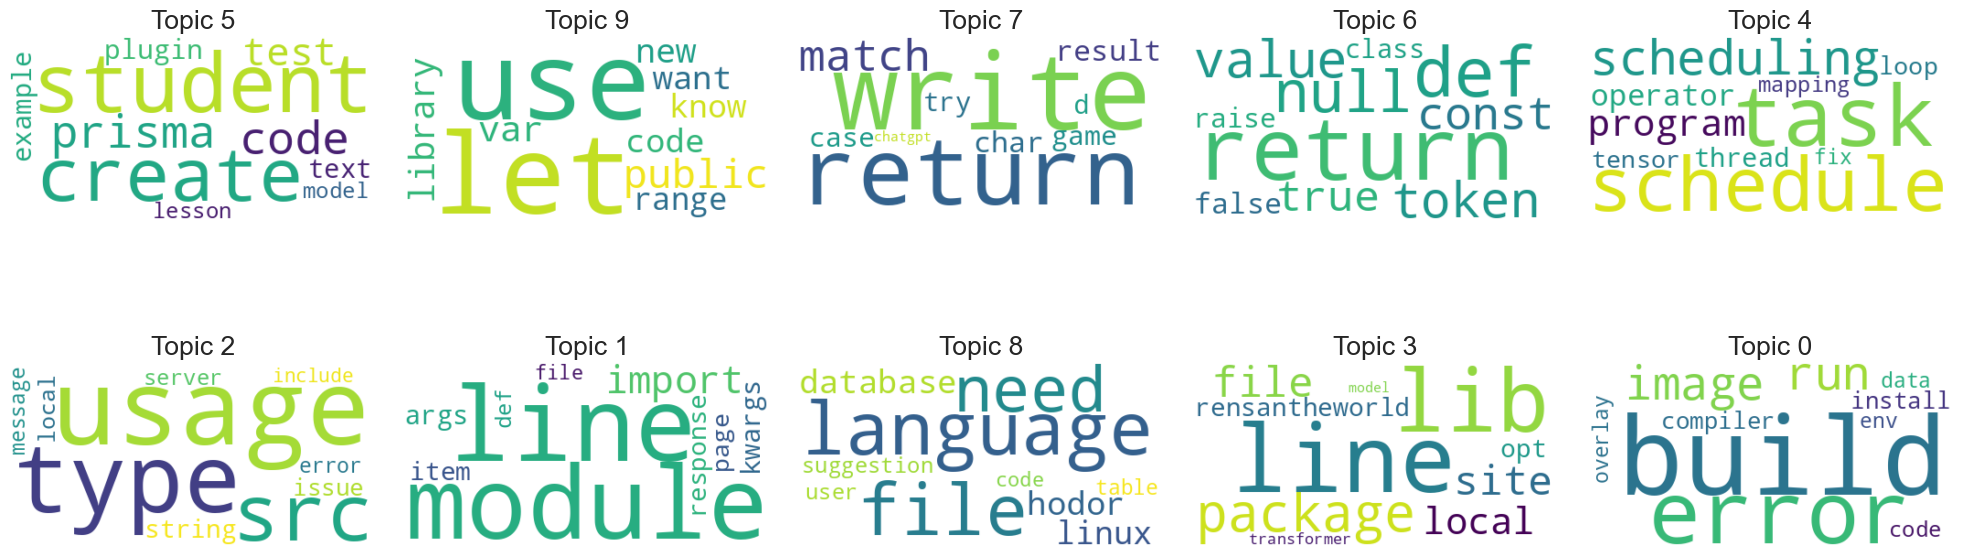

In [11]:
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(top_ten_topics):  # draw the top 10
        fig.add_subplot(ax)
        topic_words = dict(lda_model.show_topic(top_ten_topics[i][0]))  # get words of top 10
        word_cloud.generate_from_frequencies(topic_words)
        plt.gca().imshow(word_cloud, interpolation='bilinear')
        plt.gca().set_title(f'Topic {top_ten_topics[i][0]}')
        plt.gca().axis('off')

plt.tight_layout()  
plt.show()

### Answer

In [12]:
data1 = list(translated_df['Translated_Answer'])
print(len(data1))
print(data1[0])

clean_data1 = [str(i).replace('\n','').replace('\r','') for i in data1]

nlp = spacy.load("en_core_web_sm")
unwanted_pipes = ["ner", "parser"]
def custom_tokenizer(doc):
    with nlp.disable_pipes(*unwanted_pipes):
        return [t.lemma_ for t in doc if t.is_alpha and not t.is_space and not t.is_punct and not t.is_stop and t.pos_ in ["ADJ", "NOUN", "VERB"]]

tokenized_data1 = list(map(custom_tokenizer, nlp.pipe(clean_data1, batch_size=32, n_process=4)))
print(tokenized_data1[0])

dct1 = corpora.Dictionary(tokenized_data1)
print('Size of vocabulary before filtering:', len(dct1))

dct1.filter_extremes(no_below=5, no_above=0.5)
print('Size of vocabulary after filtering:', len(dct1))

example_mappings1 = [(i, dct1.token2id[i]) for i in tokenized_data1[0][:10] if i in dct1.token2id]
print("Example mappings:", example_mappings1)

bow1 = [dct1.doc2bow(i) for i in tokenized_data1]

1780
The reason the hamburger menu is displayed from the beginning and cannot be toggled on or off is because display: none; is set in the container class. This causes the menu to be hidden from the start. To fix this, follow the steps below. To hide the initial display of the container class, delete the display: none; style. After modification, the header.css file will look like this: [CODE_BLOCK_0]This will cause the menu to be hidden initially, and will become visible when you click the hamburger icon.


/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' mod

['reason', 'hamburger', 'menu', 'display', 'beginning', 'toggle', 'display', 'set', 'container', 'class', 'cause', 'menu', 'hide', 'start', 'fix', 'follow', 'step', 'hide', 'initial', 'display', 'container', 'class', 'delete', 'display', 'style', 'modification', 'file', 'look', 'cause', 'menu', 'hide', 'visible', 'click', 'hamburger', 'icon']
Size of vocabulary before filtering: 8471
Size of vocabulary after filtering: 2272
Example mappings: [('reason', 17), ('hamburger', 10), ('menu', 15), ('display', 6), ('beginning', 0), ('toggle', 22), ('display', 6), ('set', 18), ('container', 4), ('class', 2)]


In [13]:
lda_model1 = models.LdaModel(corpus=bow1, num_topics=10, passes=10, alpha='auto', eta='auto', id2word=dct1, random_state=0)
lda_model1.print_topics()

[(0,
  '0.015*"code" + 0.015*"error" + 0.014*"need" + 0.014*"issue" + 0.014*"version" + 0.014*"use" + 0.012*"run" + 0.011*"library" + 0.011*"step" + 0.011*"package"'),
 (1,
  '0.057*"file" + 0.033*"model" + 0.015*"directory" + 0.011*"click" + 0.009*"use" + 0.009*"code" + 0.009*"path" + 0.009*"task" + 0.009*"menu" + 0.009*"open"'),
 (2,
  '0.044*"code" + 0.024*"generate" + 0.021*"step" + 0.015*"document" + 0.014*"option" + 0.014*"result" + 0.012*"phrase" + 0.012*"function" + 0.011*"source" + 0.010*"prompt"'),
 (3,
  '0.079*"die" + 0.044*"der" + 0.029*"den" + 0.025*"dass" + 0.019*"und" + 0.019*"있습니다" + 0.017*"das" + 0.015*"werden" + 0.014*"ist" + 0.012*"response"'),
 (4,
  '0.018*"datum" + 0.018*"message" + 0.013*"method" + 0.013*"object" + 0.013*"binary" + 0.011*"stream" + 0.009*"proxy" + 0.009*"provide" + 0.009*"text" + 0.008*"model"'),
 (5,
  '0.029*"library" + 0.022*"use" + 0.014*"function" + 0.012*"code" + 0.011*"need" + 0.011*"file" + 0.011*"log" + 0.010*"create" + 0.010*"run" + 0.

In [14]:
topics1 = list(lda_model1.get_document_topics(bow1, minimum_probability=0))
for i in range(10):
    print(f"Topic {i} proportion: {100*sum([pair[i][1] for pair in topics1])/len(topics1):.1f}%")

Topic 0 proportion: 18.0%
Topic 1 proportion: 11.8%
Topic 2 proportion: 7.8%
Topic 3 proportion: 5.1%
Topic 4 proportion: 9.4%
Topic 5 proportion: 13.2%
Topic 6 proportion: 6.5%
Topic 7 proportion: 9.7%
Topic 8 proportion: 10.3%
Topic 9 proportion: 8.2%


In [17]:
def get_top_ten_topics(model):
    topic_weights = model.get_topics().sum(axis=1)  # total weights of each topic
    top_indices = topic_weights.argsort()[::-1][:10]  # index for top 10 ranked by weights
    top_topics = model.show_topics(num_topics=10, formatted=False)  # get the topic and words
    return [(index, top_topics[index]) for index in top_indices]

top_ten_topics = get_top_ten_topics(lda_model)
print("Top 10 Topics by Weight:")
for index, topic in top_ten_topics:
    print(f"Topic {index}: {topic}")

Top 10 Topics by Weight:
Topic 5: (5, [('student', 0.020650297), ('create', 0.017073335), ('prisma', 0.016902285), ('code', 0.016857997), ('test', 0.015216368), ('plugin', 0.014802433), ('example', 0.0142172845), ('text', 0.014003553), ('lesson', 0.013698598), ('model', 0.013688578)])
Topic 9: (9, [('let', 0.025440127), ('use', 0.024561517), ('public', 0.019303337), ('var', 0.01608091), ('library', 0.014529132), ('new', 0.013593278), ('code', 0.0126470225), ('want', 0.012442977), ('know', 0.011511597), ('range', 0.0108674755)])
Topic 7: (7, [('write', 0.023136042), ('return', 0.018146234), ('match', 0.016990224), ('result', 0.015945034), ('char', 0.01582626), ('case', 0.013744471), ('game', 0.013739629), ('try', 0.012941588), ('d', 0.01289163), ('chatgpt', 0.012336448)])
Topic 6: (6, [('return', 0.07028187), ('def', 0.03961924), ('null', 0.026928557), ('value', 0.021929903), ('token', 0.021599706), ('const', 0.018733783), ('true', 0.016359568), ('false', 0.014535951), ('raise', 0.01448

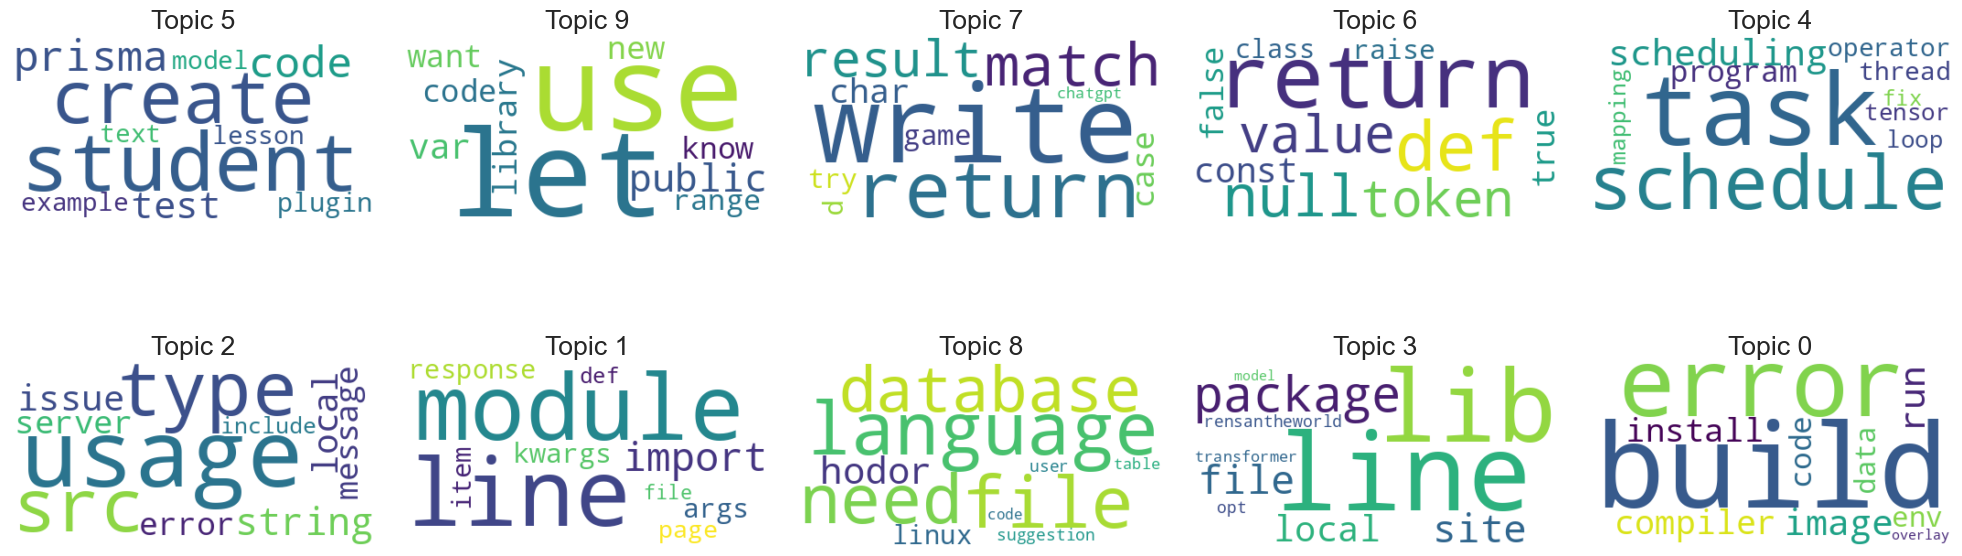

In [18]:
word_cloud = WordCloud(background_color='white', max_words=10)
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

for i, ax in enumerate(axes.flatten()):
    if i < len(top_ten_topics):  # draw the top 10
        fig.add_subplot(ax)
        topic_words = dict(lda_model.show_topic(top_ten_topics[i][0]))  # get words of top 10
        word_cloud.generate_from_frequencies(topic_words)
        plt.gca().imshow(word_cloud, interpolation='bilinear')
        plt.gca().set_title(f'Topic {top_ten_topics[i][0]}')
        plt.gca().axis('off')

plt.tight_layout()  
plt.show()